In [ ]:
%tensorflow_version 1.x


TensorFlow 1.x selected.


In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
import pickle
import tensorflow as tf
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report


%matplotlib inline

sns.set(style='whitegrid',palette='muted',font_scale=1.5)

RANDOM_SEED = 42

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
from google.colab import drive

drive.mount('/content/drive')


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
columns = ['user','activity','timestamp','x-axis','y-axis','z-axis']
df = pd.read_csv('/content/drive/My Drive/project-sem4/inputs.txt',names=columns)
df = df.dropna()
df.head()

,user,activity,timestamp,x-axis,y-axis,z-axis
0,33,Jogging,49105962326000,-0.694638,12.680544,0.503953
1,33,Jogging,49106062271000,5.012288,11.264028,0.953424
2,33,Jogging,49106112167000,4.903325,10.882658,-0.081722
3,33,Jogging,49106222305000,-0.612916,18.496431,3.023717
4,33,Jogging,49106332290000,-1.184970,12.108489,7.205164


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1098208 entries, 0 to 1098208
Data columns (total 6 columns):
 #   Column     Non-Null Count    Dtype  
---  ------     --------------    -----  
 0   user       1098208 non-null  int64  
 1   activity   1098208 non-null  object 
 2   timestamp  1098208 non-null  int64  
 3   x-axis     1098208 non-null  float64
 4   y-axis     1098208 non-null  float64
 5   z-axis     1098208 non-null  float64
dtypes: float64(3), int64(2), object(1)
memory usage: 58.7+ MB


In [ ]:
countOfActivity = df['activity'].value_counts()
print(countOfActivity)

Walking       424399
Jogging       342179
Upstairs      122869
Downstairs    100427
Sitting        59939
Standing       48395
Name: activity, dtype: int64


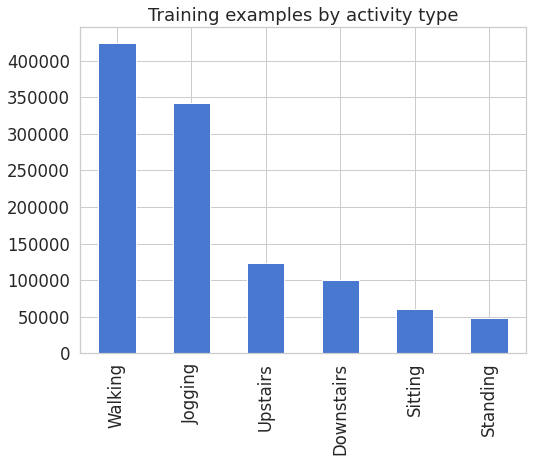

In [ ]:
countOfActivity.plot(kind='bar',title='Training examples by activity type',figsize=(8,6))

# No of sampls belonging to each volunteer

In [ ]:
countOfActivityPerPerson = df['user'].value_counts()
print(countOfActivityPerPerson)
totalActivity = countOfActivityPerPerson.sum()
print('Total number of activity recorded: ',str(totalActivity))

20    56632
19    45383
31    44282
8     41188
29    38245
14    38192
13    37093
34    35948
32    35506
21    35436
3     35161
27    34959
10    34883
18    32812
12    32641
26    32578
36    32261
11    31658
7     30967
1     29978
6     29704
33    29453
5     28510
15    28155
24    25736
23    25673
30    25335
2     23525
35    22394
22    22310
17    22020
28    21358
16    20470
25    13468
9     12923
4     11371
Name: user, dtype: int64
Total number of activity recorded:  1098208


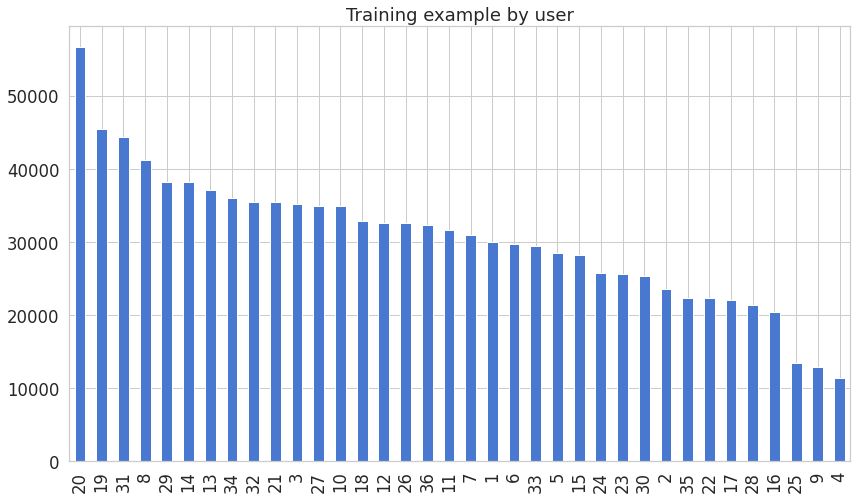

In [ ]:
countOfActivityPerPerson.plot(kind='bar',title='Training example by user',figsize=(14,8))

# How does accelerometer data looks like visually:


In [ ]:
def plot_activity(activity,df):
  extractRowsOfActivity = (df['activity']==activity)
  data = df[extractRowsOfActivity]
  data = data[['x-axis','y-axis','z-axis']]
  data = data[:200]


  ax = data.plot(subplots=True,figsize=(12,8),title=activity)

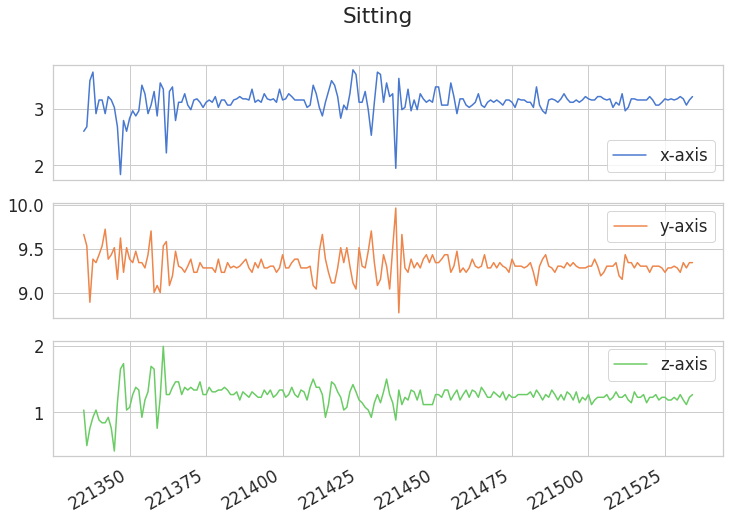

In [ ]:
plot_activity('Sitting',df)

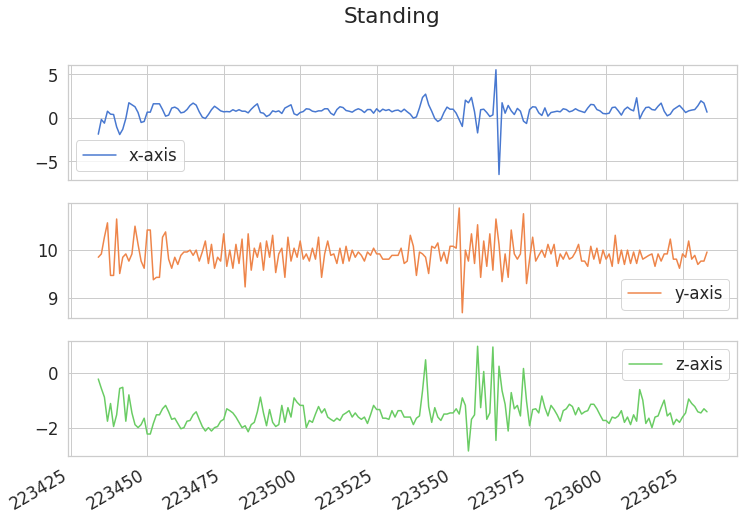

In [ ]:
plot_activity('Standing',df)

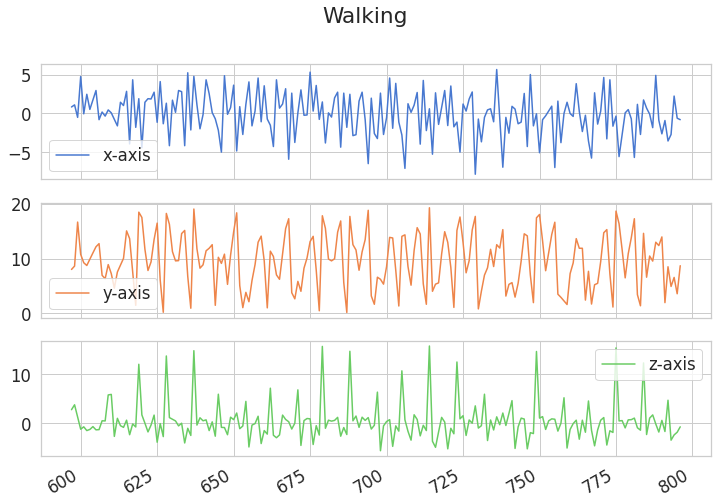

In [ ]:
plot_activity('Walking',df)

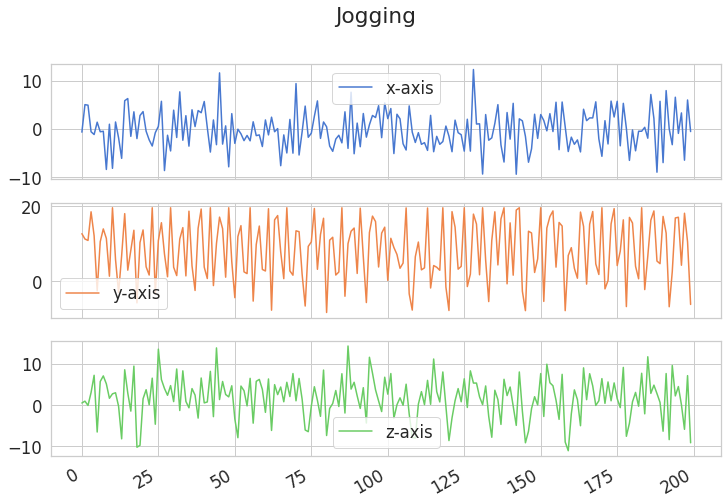

In [ ]:
plot_activity('Jogging',df)

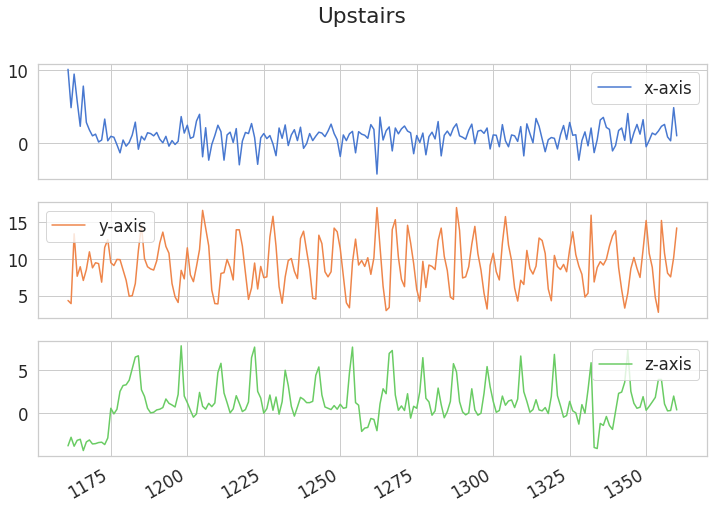

In [ ]:
plot_activity('Upstairs',df)

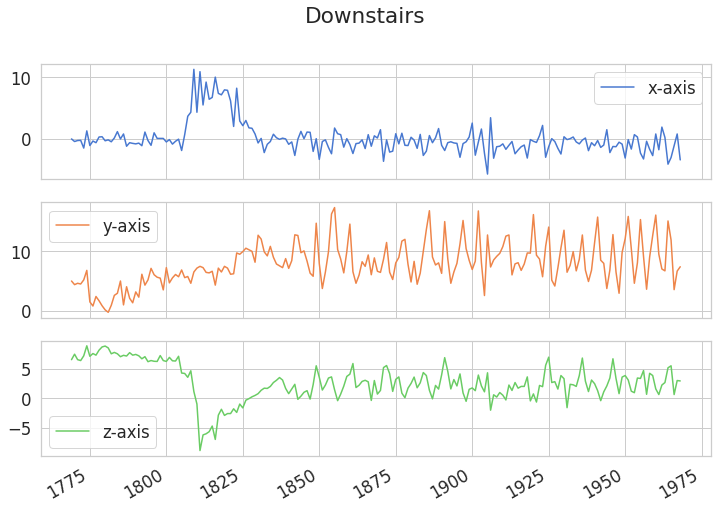

In [ ]:
plot_activity('Downstairs',df)

# DATA preprocessing



*   Modelling time series
*   LSTM RNN
*   200 training sample sequences
*   Dividing the whole data into multiple time slices





In [ ]:
N_TIME_STEPS = 200
N_FEATURES = 3
steps = 20
segments = []
labels = []
for i in range(0,len(df)-N_TIME_STEPS,steps): #will give starting point of each batch
  xs = df['x-axis'].values[i:i+N_TIME_STEPS]
  ys = df['y-axis'].values[i:i+N_TIME_STEPS]
  zs = df['z-axis'].values[i:i+N_TIME_STEPS]
  label = stats.mode(df['activity'][i:i+N_TIME_STEPS]) #returns two arrays modes and count
  label = label[0][0] #to get actual count of mode
  segments.append([xs,ys,zs])
  labels.append(label)

In [ ]:
np.array(segments).shape

(54901, 3, 200)

# Transforming shape of segments

In [ ]:
reshaped_segments = np.asarray(segments,dtype=np.float32).reshape(-1,N_TIME_STEPS,N_FEATURES)
print(reshaped_segments.shape)

(54901, 200, 3)


# One hot encoding of labels

In [ ]:
labels = np.asarray(pd.get_dummies(labels),dtype=np.float32)


In [ ]:
print(labels)
print(labels.shape)

[[0. 1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0.]
 ...
 [0. 0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0.]]
(54901, 6)


In [ ]:
X_train,X_test,y_train,y_test = train_test_split(reshaped_segments,labels,test_size=0.2,random_state=RANDOM_SEED)

In [ ]:
len(X_train)

43920

In [ ]:
len(X_test)

10981

# Building the model




*   2 fully connected and 2 LSTM layers
*   64 units each





In [ ]:
N_CLASSES = 6
N_HIDDEN_UNITS = 64

In [ ]:
def create_LSTM_model(inputs):
  W = {
      'hidden': tf.Variable(tf.random_normal([N_FEATURES,N_HIDDEN_UNITS])), #3*64
      'output' : tf.Variable(tf.random_normal([N_HIDDEN_UNITS,N_CLASSES]))  #64*6
        
  }

  biases = {
      'hidden': tf.Variable(tf.random_normal([N_HIDDEN_UNITS],mean=1.0)),#64
      'output': tf.Variable(tf.random_normal([N_CLASSES])) #64
  }
  X = tf.transpose(inputs,[1,0,2])
  X = tf.reshape(X,[-1,N_FEATURES])
  hidden = tf.nn.relu(tf.matmul(X,W['hidden'])+biases['hidden'])
  hidden = tf.split(hidden,N_TIME_STEPS,0)

  #Stack 2 LSTM layers
  lstm_layers = [tf.contrib.rnn.BasicLSTMCell(N_HIDDEN_UNITS,forget_bias=1.0) for _ in range(2)] #create 2 LSTM layer
  lstm_layers = tf.contrib.rnn.MultiRNNCell(lstm_layers) #stacks them

  outputs,_ = tf.contrib.rnn.static_rnn(lstm_layers,hidden,dtype=tf.float32)# creates a LSTM network out of LSTM layers

  #get output for the last time step
  lstm_last_output = outputs[-1]

  return tf.matmul(lstm_last_output,W['output']) + biases['output']


# Creating place holders

In [ ]:
tf.reset_default_graph()
X = tf.placeholder(tf.float32,[None,N_TIME_STEPS,N_FEATURES],name='input') #X values that must be fed using fed dict
Y = tf.placeholder(tf.float32,[None,N_CLASSES]) #Y values that must be fed using fed dict


# Creating the model

In [ ]:
pred_Y = create_LSTM_model(X)
pred_softmax = tf.nn.softmax(pred_Y,name="y_")


The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
This class is equivalent as tf.keras.layers.LSTMCell, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
This class is equivalent as tf.keras.layers.StackedRNNCells, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
Please use `keras.layers.RNN(cell, unroll=True)`, which is equivalent to this API
Instructions for updating:
Please use `layer.add_weight` method instead.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


# L2 Regularization and Loss function

In [ ]:
L2_LOSS = 0.0015
l2 = L2_LOSS *\
     sum(tf.nn.l2_loss(tf_var) for tf_var in tf.trainable_variables())
loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=pred_Y,labels=Y)) + l2



Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.



# optimzer and Accuracy

In [ ]:
LEARNING_RATE = 0.0025
optimizer = tf.train.AdamOptimizer(learning_rate=LEARNING_RATE).minimize(loss)

correct_pred = tf.equal(tf.argmax(pred_softmax,1),tf.argmax(Y,1)) #finding the highest probablity prediction
accuracy = tf.reduce_mean(tf.cast(correct_pred,dtype=tf.float32))



# TRAINING

In [ ]:
N_EPOCHS = 50
BATCH_SIZE = 1024

In [ ]:

saver = tf.train.Saver()

history = dict(train_loss=[], 
                     train_acc=[], 
                     test_loss=[], 
                     test_acc=[])

sess=tf.InteractiveSession()
sess.run(tf.global_variables_initializer())

train_count = len(X_train)

for i in range(1, N_EPOCHS + 1):
    for start, end in zip(range(0, train_count, BATCH_SIZE),
                          range(BATCH_SIZE, train_count + 1,BATCH_SIZE)):
        sess.run(optimizer, feed_dict={X: X_train[start:end],
                                       Y: y_train[start:end]})

    _, acc_train, loss_train = sess.run([pred_softmax, accuracy, loss], feed_dict={
                                            X: X_train, Y: y_train})

    _, acc_test, loss_test = sess.run([pred_softmax, accuracy, loss], feed_dict={
                                            X: X_test, Y: y_test})

    history['train_loss'].append(loss_train)
    history['train_acc'].append(acc_train)
    history['test_loss'].append(loss_test)
    history['test_acc'].append(acc_test)

    if i != 1 and i % 10 != 0:
        continue

    print(f'epoch: {i} train accuracy: {acc_test} loss: {loss_test}') #test
    
predictions, acc_final, loss_final = sess.run([pred_softmax, accuracy, loss], feed_dict={X: X_test, Y: y_test})

print()
print(f'final results: accuracy: {acc_final} loss: {loss_final}')

epoch: 1 train accuracy: 0.791549026966095 loss: 1.3532508611679077
epoch: 10 train accuracy: 0.8885347247123718 loss: 0.7489931583404541
epoch: 20 train accuracy: 0.9496402740478516 loss: 0.46645882725715637
epoch: 30 train accuracy: 0.9624806642532349 loss: 0.35764992237091064
epoch: 40 train accuracy: 0.9677624702453613 loss: 0.296139657497406
epoch: 50 train accuracy: 0.9708587527275085 loss: 0.2533559799194336

final results: accuracy: 0.9708587527275085 loss: 0.2533559799194336


In [ ]:

# pickle.dump(predictions, open("predictions.p", "wb"))
# pickle.dump(history, open("history.p", "wb"))
# tf.train.write_graph(sess.graph_def, '.', './checkpoint/har.pbtxt') 
# saver.save(sess, save_path = "./checkpoint/har.ckpt")
# sess.close()

In [ ]:
history = pickle.load(open("history.p","rb"))
predictions = pickle.load(open("predictions.p","rb"))

In [ ]:
print(classification_report(max_test,max_predictions))

              precision    recall  f1-score   support

           0       0.88      0.93      0.91      1059
           1       0.99      0.99      0.99      3447
           2       0.97      0.98      0.98       576
           3       0.98      0.97      0.98       436
           4       0.91      0.91      0.91      1208
           5       0.99      0.98      0.99      4255

    accuracy                           0.97     10981
   macro avg       0.95      0.96      0.96     10981
weighted avg       0.97      0.97      0.97     10981



# Evaluation-Creating confusion matrix

In [ ]:
plt.figure(figsize=(12,8))

plt.plot(np.array(history['train_loss']),"r--",label='Train loss')
plt.plot(np.array(history['train_acc']),"g--",label='Train acc')

plt.plot(np.array(history['test_loss']),"r--",label="Test loss")
plt.plot(np.array(history['test_acc']),"g--",label="Test acc")

plt.title("Training session's progress over iterations ")
plt.legend(loc='upper right',shadow=True)
plt.ylabel('Training progress (Loss or accuracy value)')
plt.xlabel('Training epochs')
plt.ylim(0)

plt.show()


In [ ]:
LABELS = ['Downstairs','Jogging','Sitting','Standing','Upstairs','Walking']

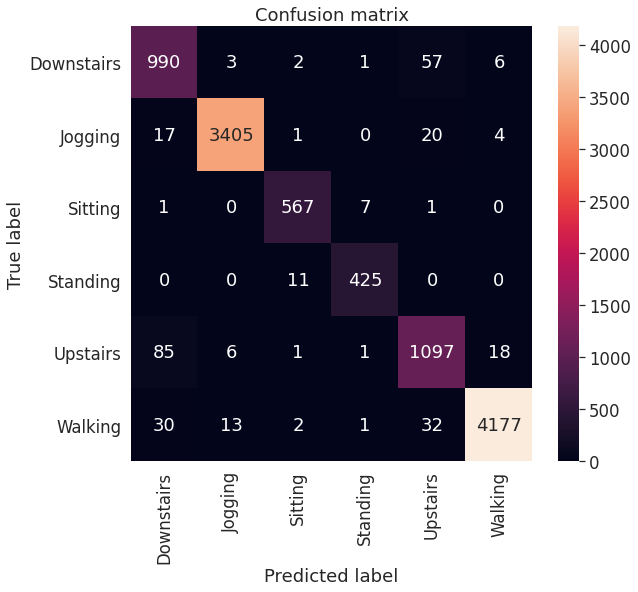

In [ ]:
max_test = np.argmax(y_test,axis=1)
max_predictions = np.argmax(predictions,axis=1)
confusion_matrix = metrics.confusion_matrix(max_test,max_predictions)
print()
plt.figure(figsize=(9,8))
sns.heatmap(confusion_matrix,xticklabels=LABELS,yticklabels=LABELS,annot=True,fmt='d')
plt.title('Confusion matrix')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

# Exporting model to android

In [ ]:
from tensorflow.python.tools import freeze_graph

MODEL_NAME = 'har'

input_graph_path = 'checkpoint/' + MODEL_NAME+'.pbtxt'
checkpoint_path = './checkpoint/' +MODEL_NAME+'.ckpt'
restore_op_name = "save/restore_all"
filename_tensor_name = "save/Const:0"
output_frozen_graph_name = 'frozen_'+MODEL_NAME+'.pb'

freeze_graph.freeze_graph(input_graph_path, input_saver="",
                          input_binary=False, input_checkpoint=checkpoint_path, 
                          output_node_names="y_", restore_op_name="save/restore_all",
                          filename_tensor_name="save/Const:0", 
                          output_graph=output_frozen_graph_name, clear_devices=True, initializer_nodes="")